In [ ]:
import requests
import os

# pdfs = {
#     "BOAXEL": "https://www.ikea.com/us/en/assembly_instructions/boaxel-wall-upright-white__AA-2341341-2-100.pdf",
# }

# output_dir = "data"
# os.makedirs(output_dir, exist_ok=True)

# for name, url in pdfs.items():
#     response = requests.get(url)
#     pdf_path = os.path.join(output_dir, f"{name}.pdf")

#     with open(pdf_path, "wb") as f:
#         f.write(response.content)

#     print(f"Downloaded {name} to {pdf_path}")

# print("Downloaded files:", os.listdir(output_dir))

Downloaded BOAXEL to data/BOAXEL.pdf
Downloaded files: ['.DS_Store', 'BOAXEL.pdf']


In [10]:
import os
from pdf2image import convert_from_path


def convert_pdfs_to_images(pdf_folder):
    pdf_files = [f for f in os.listdir(pdf_folder) if f.endswith(".pdf")]
    all_images = {}

    for doc_id, pdf_file in enumerate(pdf_files):
        pdf_path = os.path.join(pdf_folder, pdf_file)
        images = convert_from_path(pdf_path)
        all_images[doc_id] = images

    return all_images


all_images = convert_pdfs_to_images("./data/")

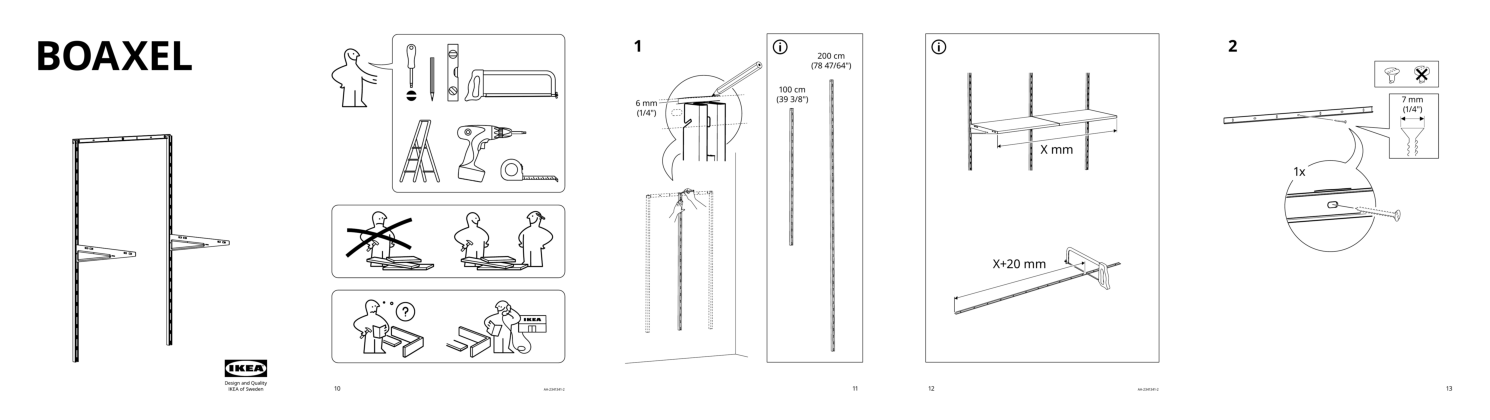

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    img = all_images[0][i]
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [13]:
from byaldi import RAGMultiModalModel

docs_retrieval_model = RAGMultiModalModel.from_pretrained("vidore/colpali-v1.2",device='cpu')

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
docs_retrieval_model.index(
    input_path="./data/boaxel.pdf", index_name="image_index", store_collection_with_index=False, overwrite=True
)

Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Index exported to .byaldi/image_index
Index exported to .byaldi/image_index


{0: 'data/boaxel.pdf'}

In [24]:
text_query = "How many people do we need to install boaxel"

results = docs_retrieval_model.search(text_query, k=3)
results

[{'doc_id': 0, 'page_num': 1, 'score': 14.375, 'metadata': {}, 'base64': None},
 {'doc_id': 0, 'page_num': 2, 'score': 9.0, 'metadata': {}, 'base64': None},
 {'doc_id': 0, 'page_num': 3, 'score': 8.875, 'metadata': {}, 'base64': None}]

In [25]:
def get_grouped_images(results, all_images):
    grouped_images = []

    for result in results:
        doc_id = result["doc_id"]
        page_num = result["page_num"]
        grouped_images.append(
            all_images[doc_id][page_num - 1]
        )  # page_num are 1-indexed, while doc_ids are 0-indexed. Source https://github.com/AnswerDotAI/byaldi?tab=readme-ov-file#searching

    return grouped_images


grouped_images = get_grouped_images(results, all_images)

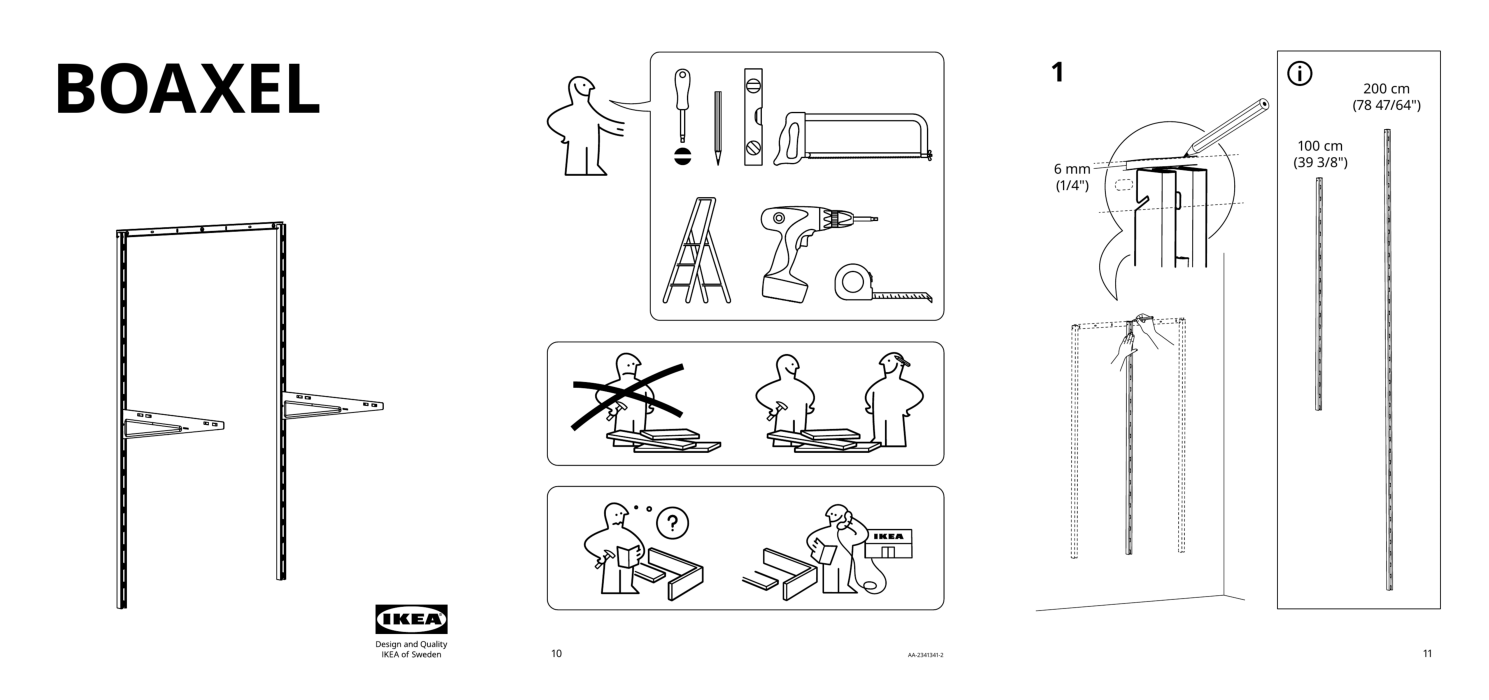

In [26]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    img = grouped_images[i]
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [32]:
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor
from qwen_vl_utils import process_vision_info
import torch

vl_model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype=torch.bfloat16,
)
vl_model.eval()

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Qwen2VLForConditionalGeneration(
  (visual): Qwen2VisionTransformerPretrainedModel(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2VLVisionBlock(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): VisionSdpaAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): VisionMlp(
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (act): QuickGELUActivation()
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
    )
    (merger): PatchMerger(
      (ln_q): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (mlp): Seq

In [33]:
min_pixels = 224 * 224
max_pixels = 1024 * 1024
vl_model_processor = Qwen2VLProcessor.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels
)

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [34]:
chat_template = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": grouped_images[0],
            },
            {
                "type": "image",
                "image": grouped_images[1],
            },
            {
                "type": "image",
                "image": grouped_images[2],
            },
            {"type": "text", "text": text_query},
        ],
    }
]

In [36]:
image_inputs, _ = process_vision_info(chat_template)
inputs = vl_model_processor(
    text=[text],
    images=image_inputs,
    padding=True,
    return_tensors="pt",
)
generated_ids = vl_model.generate(**inputs, max_new_tokens=500)
generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
output_text = vl_model_processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

In [37]:
print(output_text[0])

To install the BOAXEL, you will need at least two people.
